In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"

usecols = [
    "iso_code", "location", "date", "population",
    "total_cases", "new_cases", "total_deaths", "new_deaths",
    "people_vaccinated", "people_fully_vaccinated", "total_boosters"
]

df = pd.read_csv(url, usecols=usecols, parse_dates=["date"])
df = df[df["location"].isin(["Serbia", "Norway", "Germany"])]

print(df.shape)
print(df.head())


(5022, 11)
       iso_code location       date  total_cases  new_cases  total_deaths  \
140411      DEU  Germany 2020-01-05          1.0        1.0           3.0   
140412      DEU  Germany 2020-01-06          1.0        0.0           3.0   
140413      DEU  Germany 2020-01-07          1.0        0.0           3.0   
140414      DEU  Germany 2020-01-08          1.0        0.0           3.0   
140415      DEU  Germany 2020-01-09          1.0        0.0           3.0   

        new_deaths  people_vaccinated  people_fully_vaccinated  \
140411         3.0                NaN                      NaN   
140412         0.0                NaN                      NaN   
140413         0.0                NaN                      NaN   
140414         0.0                NaN                      NaN   
140415         0.0                NaN                      NaN   

        total_boosters  population  
140411             NaN    83369840  
140412             NaN    83369840  
140413            

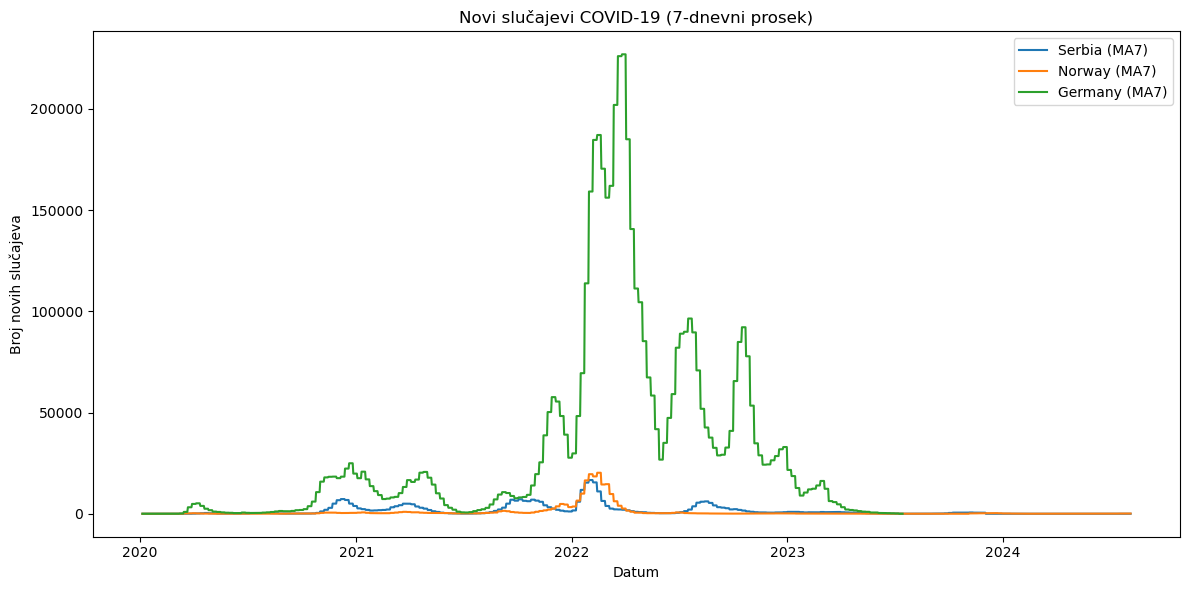

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for country in ["Serbia", "Norway", "Germany"]:
    sub = df[df["location"] == country].copy()
    sub = sub.sort_values("date")
    sub["new_cases_ma7"] = sub["new_cases"].rolling(7, min_periods=1).mean()
    sub["new_cases"] = sub["new_cases"].fillna(0)
    sub["new_cases_pm"] = sub["new_cases"] / (sub["population"]/1_000_000)

    plt.plot(sub["date"], sub["new_cases_ma7"], label=f"{country} (MA7)")

plt.title("Novi slučajevi COVID-19 (7-dnevni prosek)")
plt.xlabel("Datum")
plt.ylabel("Broj novih slučajeva")
plt.legend()
plt.tight_layout()
plt.show()

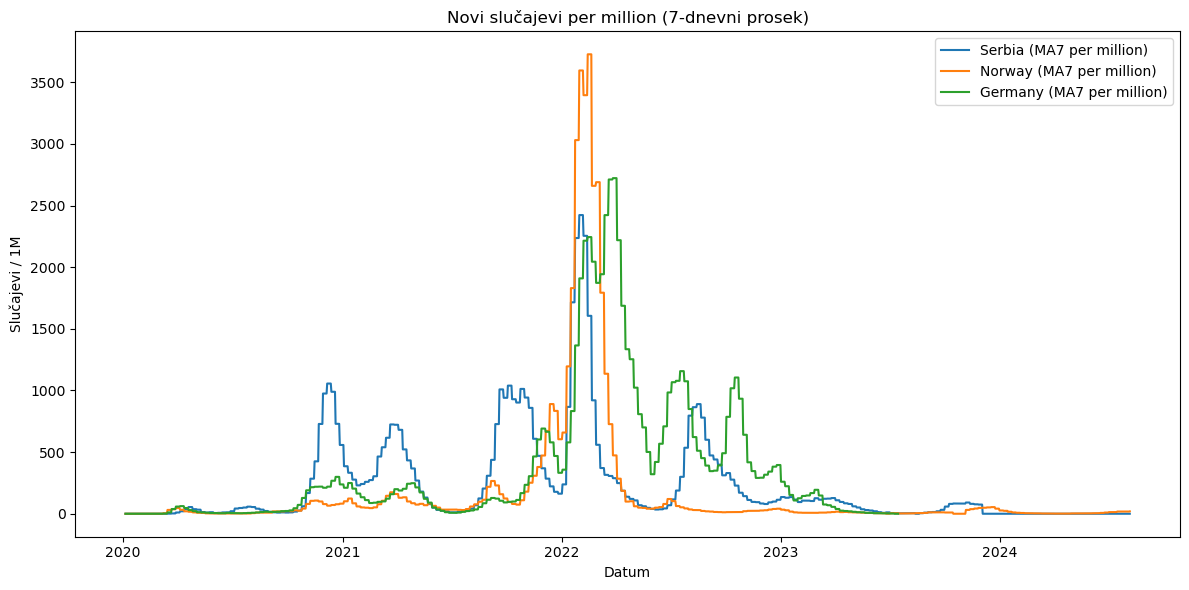

In [ ]:
import numpy as np

df["new_cases_pm"]  = df["new_cases"]  / (df["population"] / 1_000_000)
df["new_deaths_pm"] = df["new_deaths"] / (df["population"] / 1_000_000)

df = df.sort_values(["location","date"]).copy()

plt.figure(figsize=(12,6))
for country in ["Serbia","Norway","Germany"]:
    sub = df[df["location"]==country].copy()
    sub["ma7_pm"] = sub["new_cases_pm"].rolling(7, min_periods=1).mean()
    plt.plot(sub["date"], sub["ma7_pm"], label=f"{country} (MA7 per million)")
plt.title("New cases per million (7-day average)")
plt.xlabel("Date"); plt.ylabel("Cases / 1M"); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
def peaks_table(sub, col="new_cases_pm"):
    sub = sub.sort_values("date").copy()
    sub["ma7"] = sub[col].rolling(7, min_periods=1).mean()
    # local maximum: value bigger than neighbors
    sub["is_peak"] = (sub["ma7"] > sub["ma7"].shift(1)) & (sub["ma7"] > sub["ma7"].shift(-1))
    return sub.loc[sub["is_peak"], ["location","date","ma7"]].sort_values("ma7", ascending=False).head(3)

peaks = []
for c in ["Serbia","Norway","Germany"]:
    peaks.append(peaks_table(df[df["location"]==c], "new_cases_pm"))
import pandas as pd
peaks_df = pd.concat(peaks, ignore_index=True)
print(peaks_df)


Empty DataFrame
Columns: [location, date, ma7]
Index: []


In [ ]:
lag_days = 21
out = []
for c in ["Serbia","Norway","Germany"]:
    sub = df[df["location"]==c].copy()
    # percent fully vaccinated
    sub["fully_pct"] = sub["people_fully_vaccinated"] / sub["population"] * 100
    sub["deaths_pm_lag"] = sub["new_deaths_pm"].shift(-lag_days)  # mortality later
    corr = sub[["fully_pct","deaths_pm_lag"]].corr().iloc[0,1]
    out.append((c, corr))
print("Lagged corr (fully% vs deaths_pm +21d):", out)


Lagged corr (fully% vs deaths_pm +21d): [('Serbia', np.float64(0.06633120730733745)), ('Norway', np.float64(0.14128859878316785)), ('Germany', np.float64(-0.016353686820934132))]


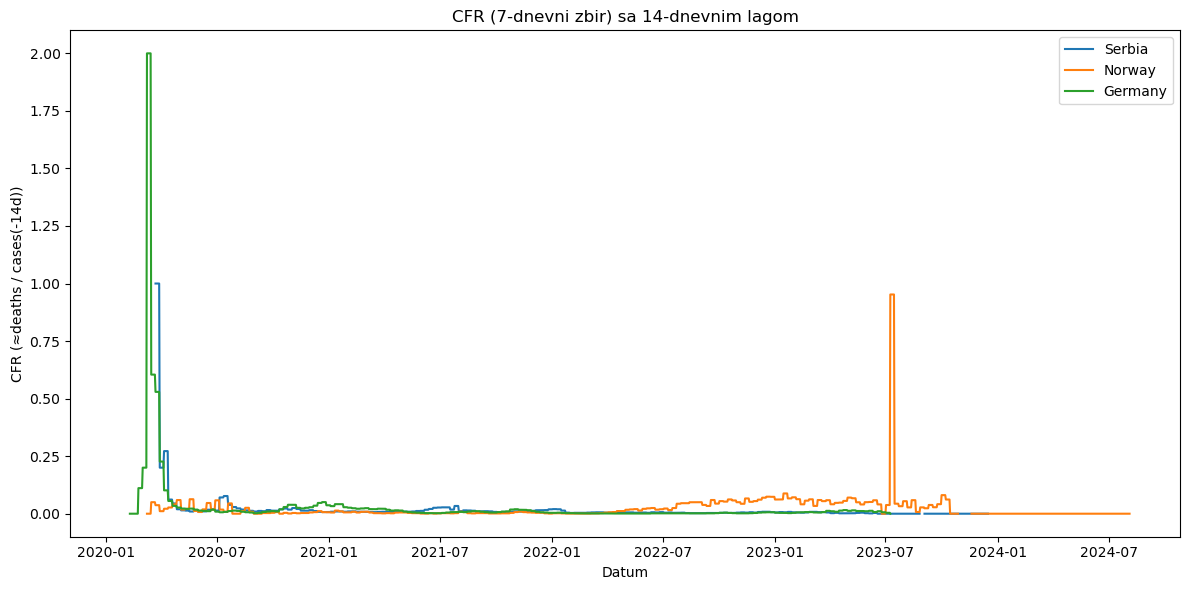

In [ ]:
def cfr_lagged(sub, lag=14):
    sub = sub.sort_values("date").copy()
    ma_cases  = sub["new_cases"].rolling(7, min_periods=7).sum()
    ma_deaths = sub["new_deaths"].rolling(7, min_periods=7).sum()
    cfr = (ma_deaths / ma_cases.shift(lag)).replace([np.inf, -np.inf], np.nan)
    sub["cfr_lagged"] = cfr
    return sub

plt.figure(figsize=(12,6))
for c in ["Serbia","Norway","Germany"]:
    cc = cfr_lagged(df[df["location"]==c], lag=14)
    plt.plot(cc["date"], cc["cfr_lagged"], label=c)
plt.title("CFR (7-day sum) with 14-day lag")
plt.xlabel("Date"); plt.ylabel("CFR (≈deaths / cases(-14d))")
plt.legend(); plt.tight_layout(); plt.show()


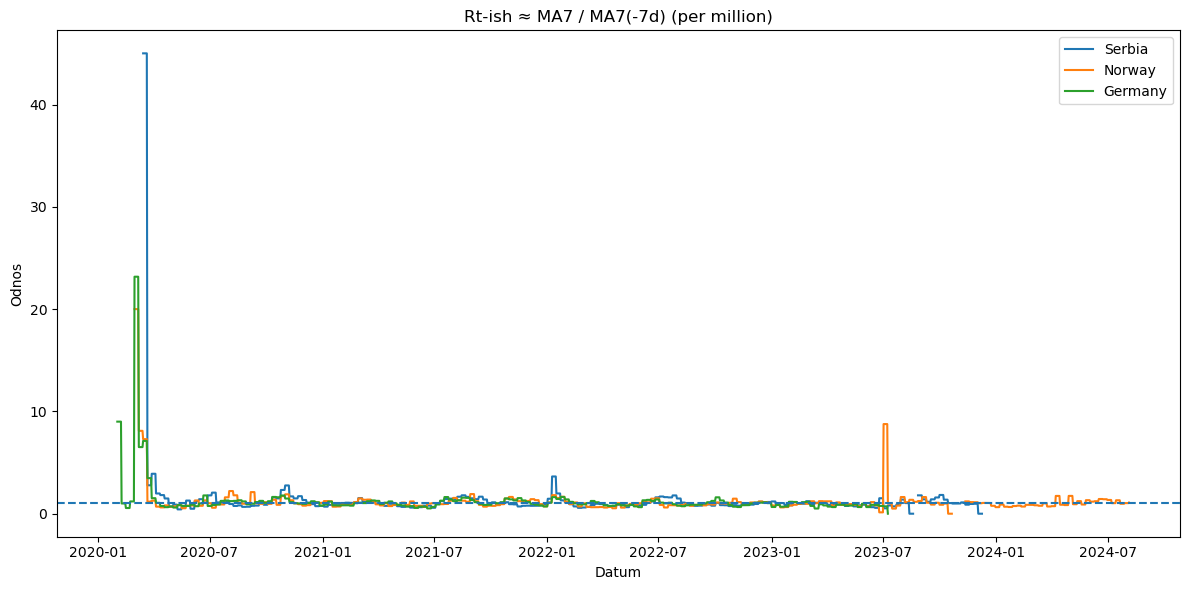

In [ ]:
plt.figure(figsize=(12,6))
for c in ["Serbia","Norway","Germany"]:
    sub = df[df["location"]==c].copy()
    ma = sub["new_cases_pm"].rolling(7, min_periods=7).mean()
    rtish = ma / ma.shift(7)
    plt.plot(sub["date"], rtish, label=c)
plt.axhline(1.0, linestyle="--")
plt.title("Rt-ish ≈ MA7 / MA7(-7d) (per million)")
plt.xlabel("Date"); plt.ylabel("Ratio"); plt.legend(); plt.tight_layout(); plt.show()

In [18]:
summaries = []
for c in ["Serbia","Norway","Germany"]:
    sub = df[df["location"]==c].copy()
    sub["ma7_pm"] = sub["new_cases_pm"].rolling(7, min_periods=1).mean()
    peak_row = sub.loc[sub["ma7_pm"].idxmax(), ["date","ma7_pm"]]
    summaries.append({
        "country": c,
        "rows": len(sub),
        "peak_date": peak_row["date"].date(),
        "peak_ma7_pm": round(peak_row["ma7_pm"], 2)
    })
pd.DataFrame(summaries).to_csv("outputs/peaks_summary.csv", index=False)
print("Saved: outputs/peaks_summary.csv")

Saved: outputs/peaks_summary.csv


In [21]:
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, UTC

COUNTRIES = ["Serbia", "Norway", "Germany"]
OUT = Path("outputs")
PLOTS = OUT / "plots"
OUT.mkdir(parents=True, exist_ok=True)
PLOTS.mkdir(parents=True, exist_ok=True)

# 1) Save lagg correlation (use 'out' alwredy calculated)
corr_df = pd.DataFrame(out, columns=["country","corr_fullypct_vs_deaths_pm_plus21"])
corr_df.to_csv(OUT / "vaccination_deaths_corr.csv", index=False)
print("Saved:", OUT / "vaccination_deaths_corr.csv")

# 2) Aggregation per week (sum) i graf: new_cases_pm
weekly = (df.set_index("date")
            .groupby("location")[["new_cases_pm","new_deaths_pm"]]
            .resample("W-MON").sum()
            .reset_index())
weekly.to_csv(OUT / "weekly_cases_deaths_pm.csv", index=False)
print("Saved:", OUT / "weekly_cases_deaths_pm.csv")

plt.figure(figsize=(12,6))
for loc, sub in weekly.groupby("location"):
    if loc in COUNTRIES:
        plt.plot(sub["date"], sub["new_cases_pm"], label=loc)
plt.title("Nedeljni novi slučajevi per million")
plt.xlabel("Nedelja"); plt.ylabel("Slučajevi / 1M"); plt.legend(); plt.tight_layout()
plt.savefig(PLOTS / "weekly_cases_pm.png", dpi=150); plt.close()
print("Saved:", PLOTS / "weekly_cases_pm.png")

# 3) Re-plot MA7 per-million (clean PNG for README)
plt.figure(figsize=(12,6))
for c in COUNTRIES:
    sub = df[df["location"]==c].copy()
    sub["ma7_pm"] = sub["new_cases_pm"].rolling(7, min_periods=1).mean()
    plt.plot(sub["date"], sub["ma7_pm"], label=f"{c} (MA7/1M)")
plt.title("Novi slučajevi per million (7-dnevni prosek)")
plt.xlabel("Datum"); plt.ylabel("Slučajevi / 1M"); plt.legend(); plt.tight_layout()
plt.savefig(PLOTS / "new_cases_pm_ma7_compare.png", dpi=150); plt.close()
print("Saved:", PLOTS / "new_cases_pm_ma7_compare.png")

# 4) Save CFR graph (use your cfr_lagged function)
plt.figure(figsize=(12,6))
for c in COUNTRIES:
    cc = cfr_lagged(df[df["location"]==c], lag=14)
    plt.plot(cc["date"], cc["cfr_lagged"], label=c)
plt.title("CFR (7-dnevni zbir) sa 14-dnevnim lagom")
plt.xlabel("Datum"); plt.ylabel("CFR (≈deaths / cases(-14d))"); plt.legend(); plt.tight_layout()
plt.savefig(PLOTS / "cfr_lagged.png", dpi=150); plt.close()
print("Saved:", PLOTS / "cfr_lagged.png")

# 5) Save Rt-ish (MA7 / MA7(-7d))
plt.figure(figsize=(12,6))
for c in COUNTRIES:
    sub = df[df["location"]==c].copy()
    ma = sub["new_cases_pm"].rolling(7, min_periods=7).mean()
    rtish = ma / ma.shift(7)
    plt.plot(sub["date"], rtish, label=c)
plt.axhline(1.0, linestyle="--")
plt.title("Rt-ish ≈ MA7 / MA7(-7d) (per million)")
plt.xlabel("Datum"); plt.ylabel("Odnos"); plt.legend(); plt.tight_layout()
plt.savefig(PLOTS / "rtish_ratio.png", dpi=150); plt.close()
print("Saved:", PLOTS / "rtish_ratio.png")

# 6) Metadata for reproducibility
data_url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
ts = datetime.now(UTC).isoformat()  

ts = ts.replace("+00:00", "Z")

with open(OUT / "metadata.txt", "w", encoding="utf-8") as f:
    f.write(f"Generated: {ts}\n")
    f.write(f"Data source: {data_url}\n")
    f.write("Countries: " + ", ".join(COUNTRIES) + "\n")

Saved: outputs/vaccination_deaths_corr.csv
Saved: outputs/weekly_cases_deaths_pm.csv
Saved: outputs/plots/weekly_cases_pm.png
Saved: outputs/plots/new_cases_pm_ma7_compare.png
Saved: outputs/plots/cfr_lagged.png
Saved: outputs/plots/rtish_ratio.png
